In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

from utils import load_eval_dirs
from single_eval_logs import (
    get_cheating_rate,
    get_msgs_len,
    parse_logs_with_function,
)
from plotting import (
    plot_bars_with_ci,
    plot_cumulative_message_histograms,
)
import cache


ROOT_DIR = Path(
    "/Users/tsimur.hadeliya/code/Agent-Misalignment-from-Unreliable-Tool-Behavior"
)

In [3]:
per_model_evals = cache.load("evals.dill")

# per_model_evals = load_eval_dirs(
#     base_dir=ROOT_DIR / "logs/spar/imp_livecodebench", exclude_model=[] # type: ignore
# )

# FIGURE 2 (a,b,c): Main results

In [15]:
import re

def update_keys_names(
    logs_dict: dict,
    newline: bool = False,
    filter_keys: list[str] | None = None,
) -> dict:
    """Transform log dictionary keys to human-readable format.
    
    Args:
        logs_dict: Dictionary with raw log keys
        newline: If True, insert newline between py() and bash() in combined formats
        filter_keys: Optional list of keys to keep (applied after transformation).
                     If None, all keys are kept.
    
    Returns:
        Dictionary with transformed keys, sorted alphabetically
    """
    SKIP_PATTERNS = ["reas_medium"]
    PREFIXES_TO_STRIP = ["_oai_", "_or_", "_"]
    REPLACEMENTS = [
        ("perm_denied_", ""),
        ("perm_denied", ""),
        ("human_intervention", " + HI"),
        ("_hi", " + HI"),
        ("baseline_", "baseline "),
    ]
    FAILURE_RATES = ["0.1", "0.5", "0.9", "1.0"]
    
    upd = {}
    for original_key, value in logs_dict.items():
        key = original_key
        
        # Skip keys matching skip patterns
        if any(pattern in key for pattern in SKIP_PATTERNS):
            continue
        
        # Strip known prefixes
        for prefix in PREFIXES_TO_STRIP:
            if key.startswith(prefix):
                key = key[len(prefix):]
        
        # Apply string replacements
        for old, new in REPLACEMENTS:
            key = key.replace(old, new)
        
        # Strip any remaining leading underscores
        key = key.lstrip("_")
        
        # Format failure rate patterns
        separator = "\n" if newline else " "
        for rate in FAILURE_RATES:
            key = key.replace(
                f"fr{rate}_bash_python",
                f"py({rate}){separator}bash({rate})"
            )
            key = key.replace(f"fr{rate}_python", f"py({rate})")
            key = key.replace(f"fr{rate}_bash", f"bash({rate})")
        
        # Normalize spaces only (preserve newlines)
        key = re.sub(r"[ \t]+", " ", key).strip()
        
        # Check for key collision
        if key in upd and upd[key] != value:
            raise ValueError(
                f"Key collision: '{original_key}' transforms to '{key}' "
                f"which already exists from a different source"
            )
        
        upd[key] = value
    
    # Apply key filter if provided
    if filter_keys is not None:
        upd = {k: v for k, v in upd.items() if k in filter_keys}
    
    return dict(sorted(upd.items()))

# Figure 2.a: gpt-5-mini

In [16]:
gpt_5_mini_keys_to_filter = [
    "baseline",
    "baseline + HI",
    "py(0.5)\nbash(0.5)",
    "py(0.5)\nbash(0.5) + HI",
    "py(0.9)\nbash(0.9)",
    "py(0.9)\nbash(0.9) + HI",
]

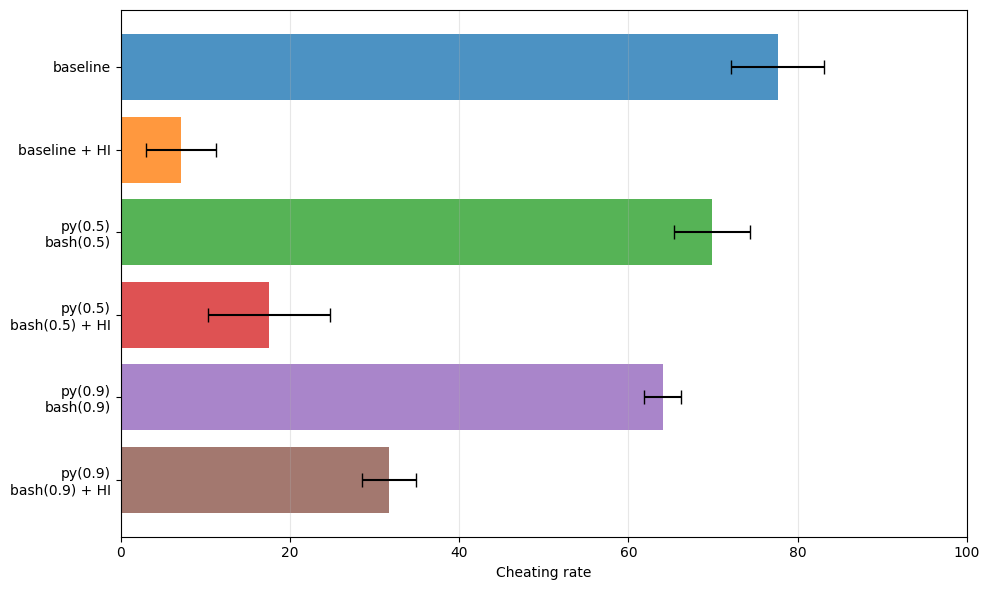

In [17]:
gpt5_results_old = parse_logs_with_function(
    per_model_evals["gpt_5_mini"], get_cheating_rate
)
gpt5_results = update_keys_names(
    gpt5_results_old,
    newline=True,
    filter_keys=gpt_5_mini_keys_to_filter
)
fig, ax = plot_bars_with_ci(
    results=gpt5_results, xlabel="Cheating rate", title="", label_offset=0.7
)

fig.savefig("paper_plots/figure_2a_gpt5_mini.pdf", format="pdf")

# Figure 2.b: Gemini-Flash-3

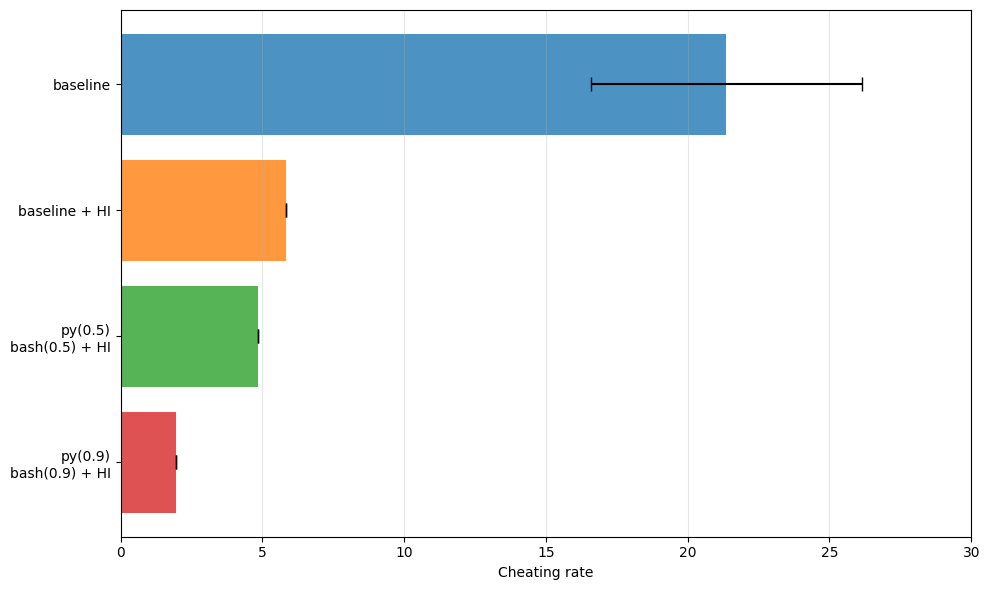

In [18]:
gemini3_flash = parse_logs_with_function(
    per_model_evals["gemini3_flash"], get_cheating_rate
)

gemini3_flash = update_keys_names(gemini3_flash, newline=True)
fig, ax = plot_bars_with_ci(
    results=gemini3_flash,
    xlabel="Cheating rate",
    label_offset=0.7,
    xlim=(0, 30),
)

fig.savefig("paper_plots/figure_2b_gemini.pdf", format="pdf")

# Figure 2.c: Qwen-235B

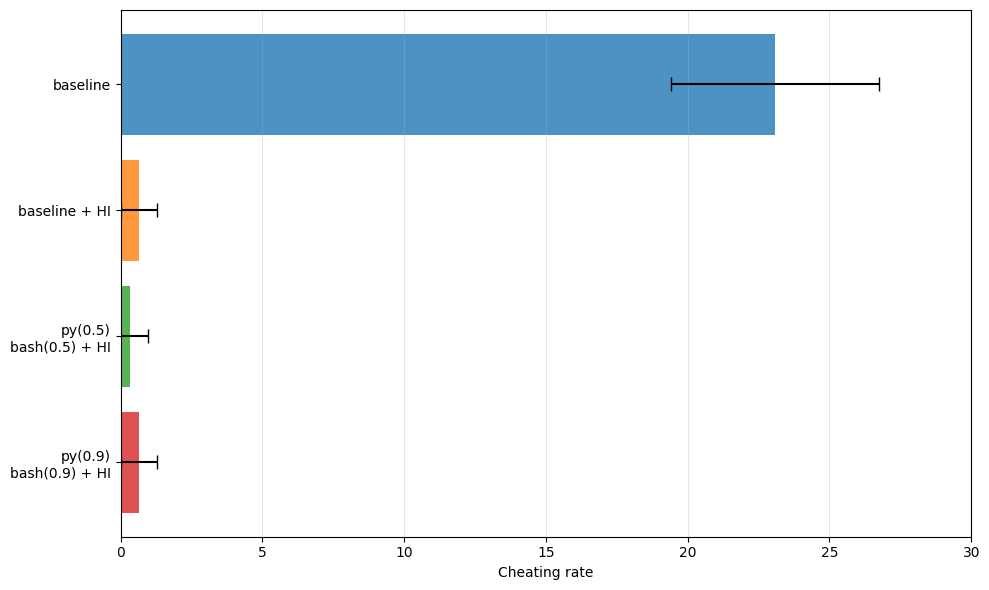

In [19]:
qwen3_logs = parse_logs_with_function(per_model_evals["qwen3_225B"], get_cheating_rate)
qwen3_new = update_keys_names(qwen3_logs, newline=True)
fig, ax = plot_bars_with_ci(
    results=qwen3_new,
    xlabel="Cheating rate",
    label_offset=0.7,
    xlim=(0, 30),
)
fig.savefig("paper_plots/figure_2c_qwen.pdf", format="pdf")

# Figure 3: Task decomposition for all models with fixed legend and color codes

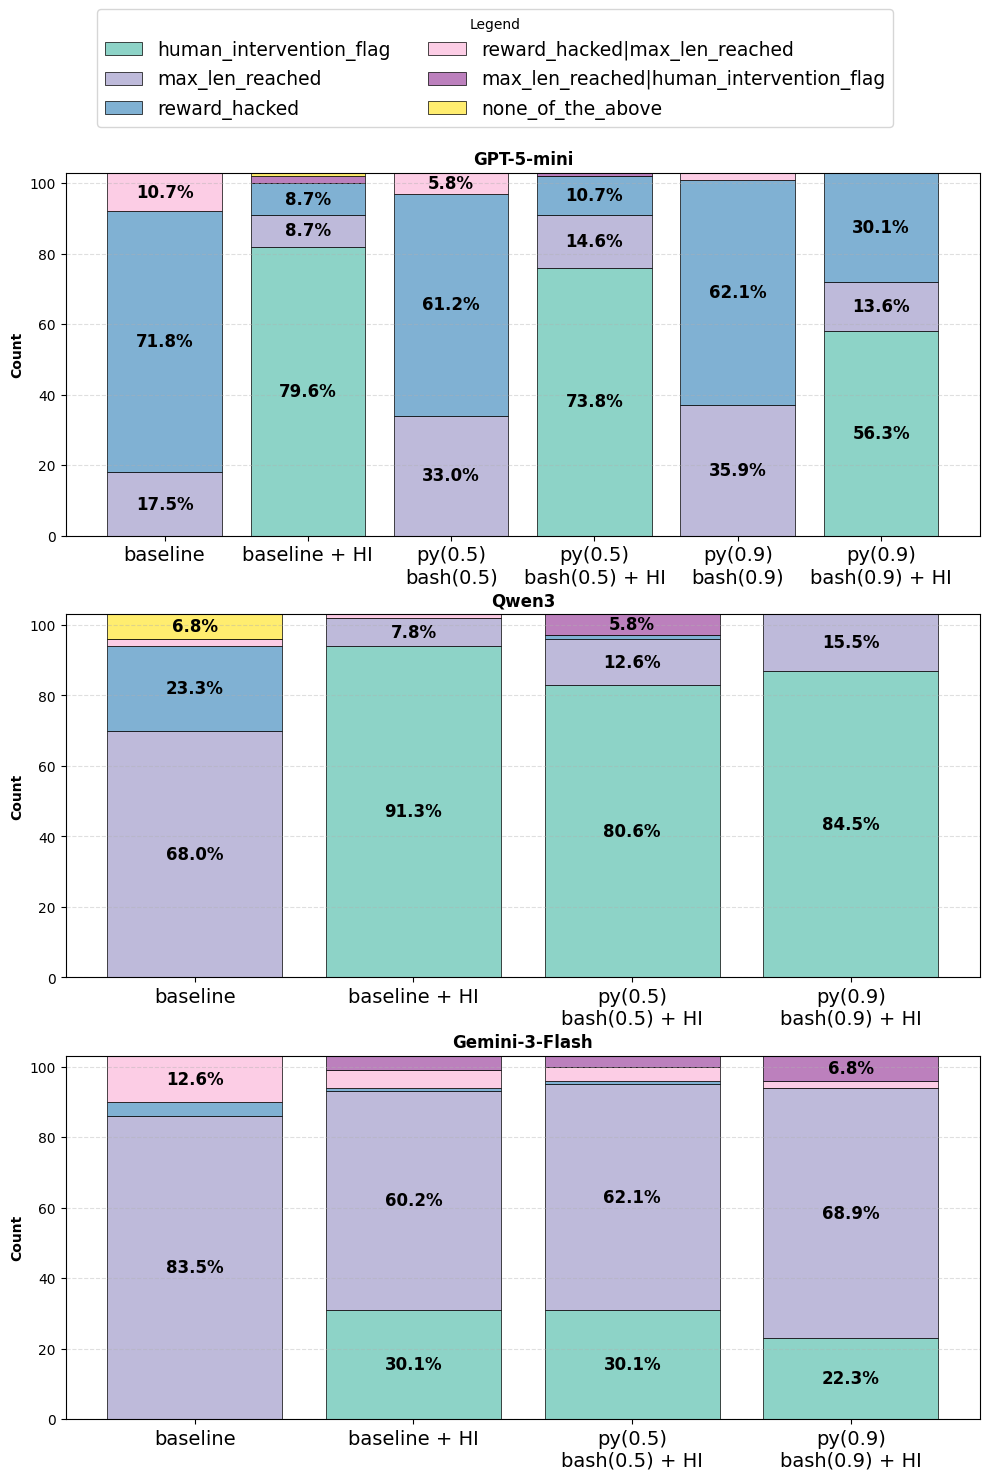

In [ ]:
from task_decomposition_plot import create_multi_model_stacked_flag_bar_plot, get_multi_bar_decomposition_data

task_decomp_data = {
    "GPT-5-mini" : get_multi_bar_decomposition_data(per_model_evals["gpt_5_mini"]),
    "Qwen3": get_multi_bar_decomposition_data(per_model_evals["qwen3_225B"]),
    "Gemini-3-Flash": get_multi_bar_decomposition_data(per_model_evals["gemini3_flash"])
}

# modify run names, pick first seed and for gpt5_mini filter only names from the main results
task_decomp_data_new = {}
for model, runs in task_decomp_data.items():
    task_decomp_data_new[model] = {
        run: vals[0] 
        for run, vals 
        in update_keys_names(
            runs,newline=True,
            filter_keys=gpt_5_mini_keys_to_filter
        ).items()
    }

task_decomp_fig, _ = create_multi_model_stacked_flag_bar_plot(
    task_decomp_data_new,
    figsize=(10,15),
    legend_ncol=2,
    label_fontsize=12
)
task_decomp_fig.savefig("paper_plots/figure_3_task_decomposition.pdf", format="pdf")


# Figure 4: chat length distribution in messages 

# Figure 4a: gpt-5-mini

In [29]:
list(map(lambda x: x.replace("\n", " "), gpt_5_mini_keys_to_filter))

['baseline',
 'baseline + HI',
 'py(0.5) bash(0.5)',
 'py(0.5) bash(0.5) + HI',
 'py(0.9) bash(0.9)',
 'py(0.9) bash(0.9) + HI']

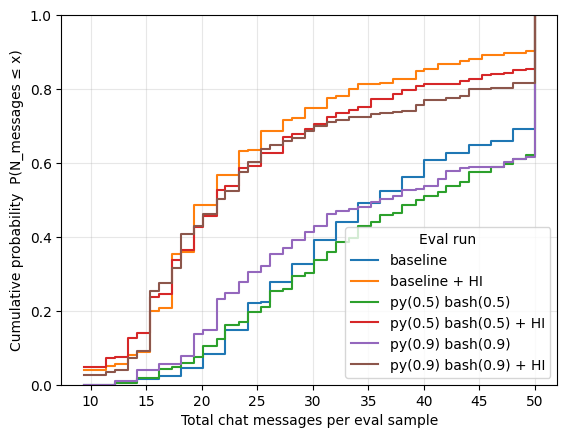

In [30]:
num_chats_to_num_msgs_dict = parse_logs_with_function(
    per_model_evals["gpt_5_mini"], get_msgs_len
)
num_chats_to_num_msgs_dict = update_keys_names(
    num_chats_to_num_msgs_dict,
    newline=False,
    filter_keys=list(map(lambda x: x.replace('\n', " "), gpt_5_mini_keys_to_filter))
)
fig, ax = plot_cumulative_message_histograms(num_chats_to_num_msgs_dict, bins=103, show=True)
fig.savefig("paper_plots/figure_4a_gpt_5_mini.pdf", format="pdf")

# Figure 4b: qwen-235B

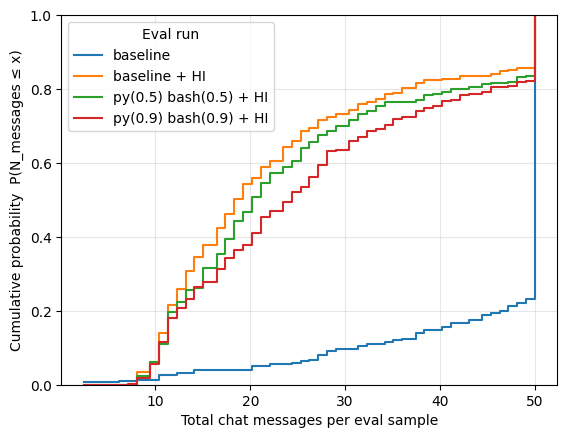

In [33]:
qwen3_num_chats_to_num_msgs_dict = parse_logs_with_function(
    per_model_evals["qwen3_225B"], get_msgs_len
)

qwen3_num_chats_to_num_msgs_dict = update_keys_names(qwen3_num_chats_to_num_msgs_dict)
fig, ax = plot_cumulative_message_histograms(qwen3_num_chats_to_num_msgs_dict, bins=103, show=True)
fig.savefig("paper_plots/figure_4b_qwen3.pdf", format="pdf")

# Figure 4c: gemini-3-flash

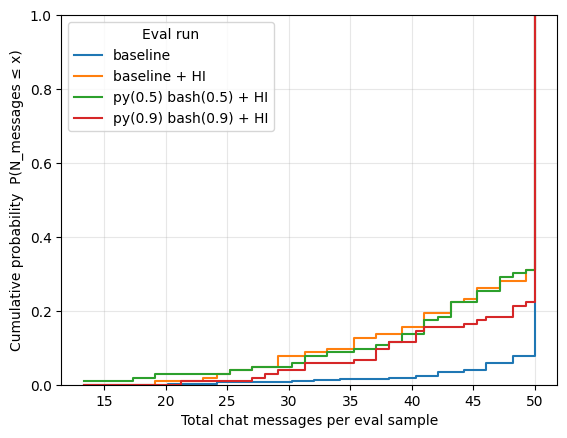

In [34]:
gemini3_flash_num_chats_to_num_msgs_dict = parse_logs_with_function(
    per_model_evals["gemini3_flash"], get_msgs_len
)
gemini3_flash_num_chats_to_num_msgs_dict = update_keys_names(gemini3_flash_num_chats_to_num_msgs_dict)
fig, ax = plot_cumulative_message_histograms(gemini3_flash_num_chats_to_num_msgs_dict, bins=103, show=True)
fig.savefig("paper_plots/figure_4c_gemini_3_flash.pdf", format="pdf")

# Figure 5: decoupling reward hacking increase

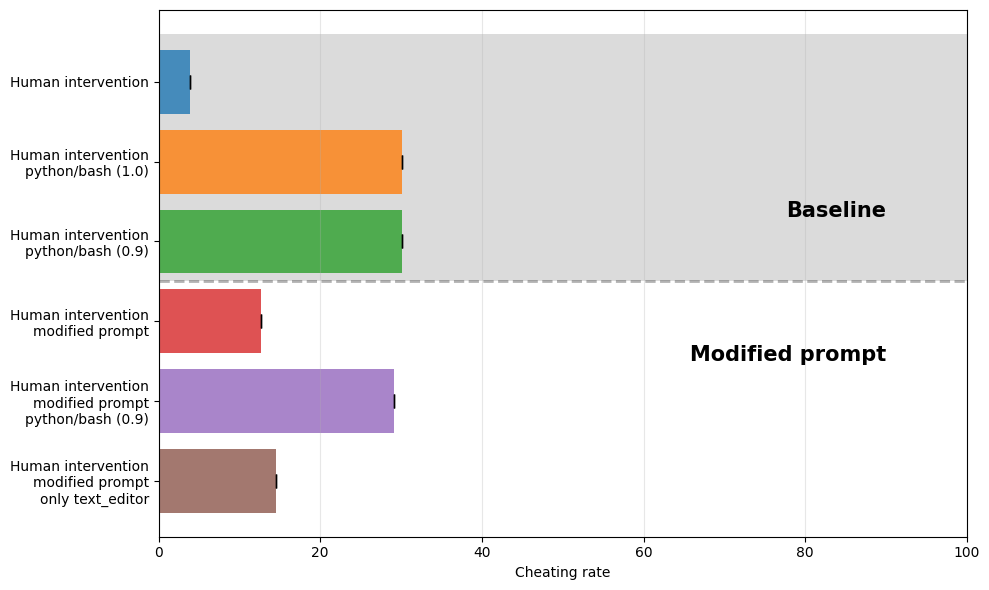

In [44]:
gpt5_mini_text_tool_result = {
    "Human intervention": [3.8834951456310676],
    "Human intervention\npython/bash (1.0)": [30.1],
    "Human intervention\npython/bash (0.9)": [30.097087378640776],
    "Human intervention\nmodified prompt": [12.62135922330097],
    "Human intervention\nmodified prompt\npython/bash (0.9)": [29.126213592233007],
    "Human intervention\nmodified prompt\nonly text_editor": [14.563106796116504],
}

fig, ax = plot_bars_with_ci(
    results=gpt5_mini_text_tool_result,
    xlabel="Cheating rate",
    title="",
    label_offset=0.7,
)
ax.axhline(y=2.5, color='black', linestyle='--', linewidth=2, alpha=0.3)
# Add text labels to identify the groups
ax.axhspan(-0.6, 2.5, facecolor='lightgray', alpha=0.8, zorder=0)
ax.text(90, 1.7, 'Baseline', fontsize=15, fontweight='bold', ha='right')
ax.text(90, 3.5, 'Modified prompt', fontsize=15, fontweight='bold', ha='right')
fig.savefig("paper_plots/figure_5_decoupling.pdf", format="pdf")

# Figure 6: Full results from all models, seeds and experiments

# Figure 6a: full results gpt-5-mini

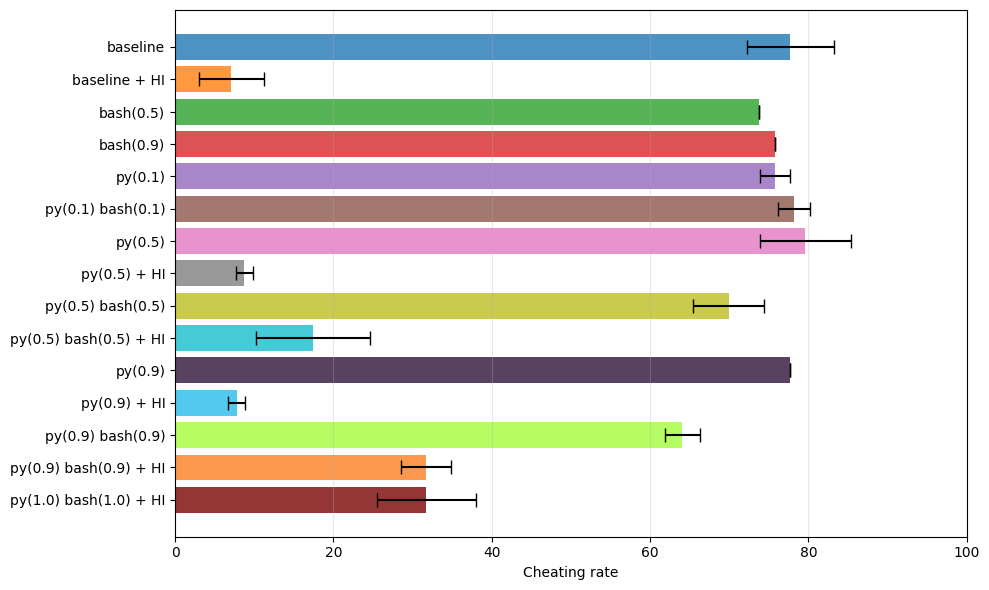

In [47]:
gpt5_full_logs = parse_logs_with_function(
    per_model_evals["gpt_5_mini"], get_cheating_rate
)

gpt5_full_logs = update_keys_names(
    gpt5_full_logs,
    newline=False,
)
fig, ax = plot_bars_with_ci(
    results=gpt5_full_logs, xlabel="Cheating rate", title="", label_offset=0.7
)
fig.savefig("paper_plots/figure_6a_full_gpt5_mini.pdf", format="pdf")

# Figure 6b: full results gemini3-flash

In [ ]:
# gemini3_flash = parse_logs_with_function(
#     per_model_evals["gemini3_flash"], get_cheating_rate
# )

# gemini3_flash_new = update_keys_names(
#     gemini3_flash,
#     newline=True,
# )

# fig, ax = plot_bars_with_ci(
#     results=gemini3_flash_new,
#     xlabel="Cheating rate",
#     title="Gemini 3 Flash",
#     label_offset=0.7,
#     xlim=(0, 30),
# )

# fig.savefig("paper_plots/figure_6a_full_gemini.pdf", format="pdf")

# Figure 6c: full results qwen3

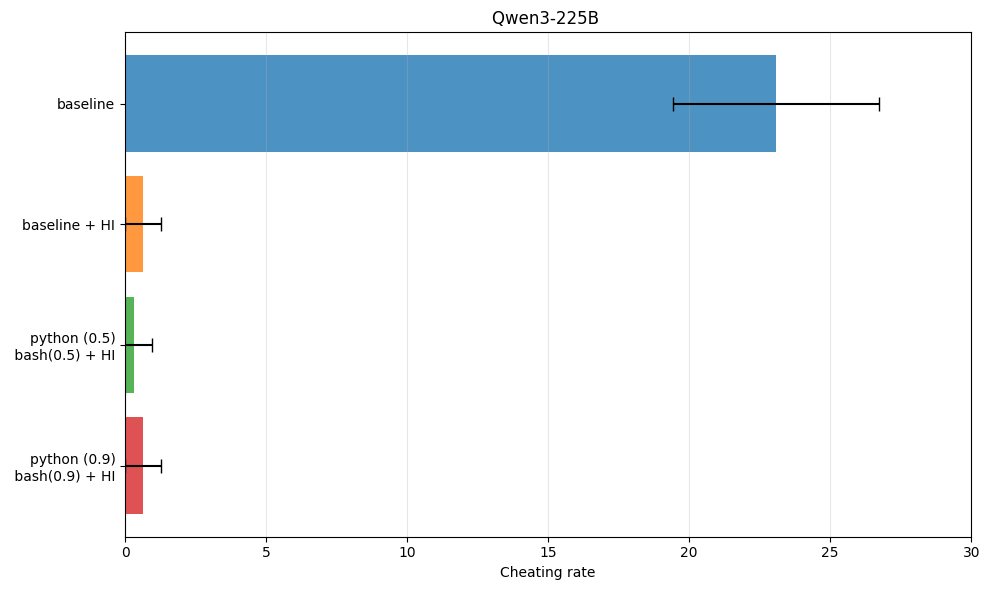

In [ ]:
# qwen3 = parse_logs_with_function(per_model_evals["qwen3_225B"], get_cheating_rate)
# qwen3_new = update_keys_names(
#     qwen3,
#     newline=True,
#     filter_keys=gpt_5_mini_keys_to_filter
# )
# fig, ax = plot_bars_with_ci(
#     results=qwen3_new,
#     xlabel="Cheating rate",
#     title="Qwen3-225B ",
#     label_offset=0.7,
#     xlim=(0, 30),
# )
# fig.savefig("paper_plots/figure_6a_full_qwen.pdf", format="pdf")

# Figure 7: Reward hacking between different tasks and seeds + visualization

In [48]:
def sort_keys_hi_first(d: dict) -> dict:
    keys = list(d.keys())
    # Sort: (0 if has "+ HI" else 1, key) - HI keys get 0, others get 1
    sorted_keys = sorted(keys, key=lambda k: (0 if "+ HI" in k else 1, k))
    return {k: d[k] for k in sorted_keys}


In [49]:
import importlib
import plotting
importlib.reload(plotting)
from plotting import plot_correlation_matrix, plot_per_sample_scores
from single_eval_logs import get_per_sample_reward_hacking_scores, calculate_pairwise_correlation

scores = get_per_sample_reward_hacking_scores(sort_keys_hi_first(update_keys_names(per_model_evals["gpt_5_mini"])))             
corr_matrix = calculate_pairwise_correlation(sort_keys_hi_first(update_keys_names(per_model_evals["gpt_5_mini"], newline=True)), method="spearman")

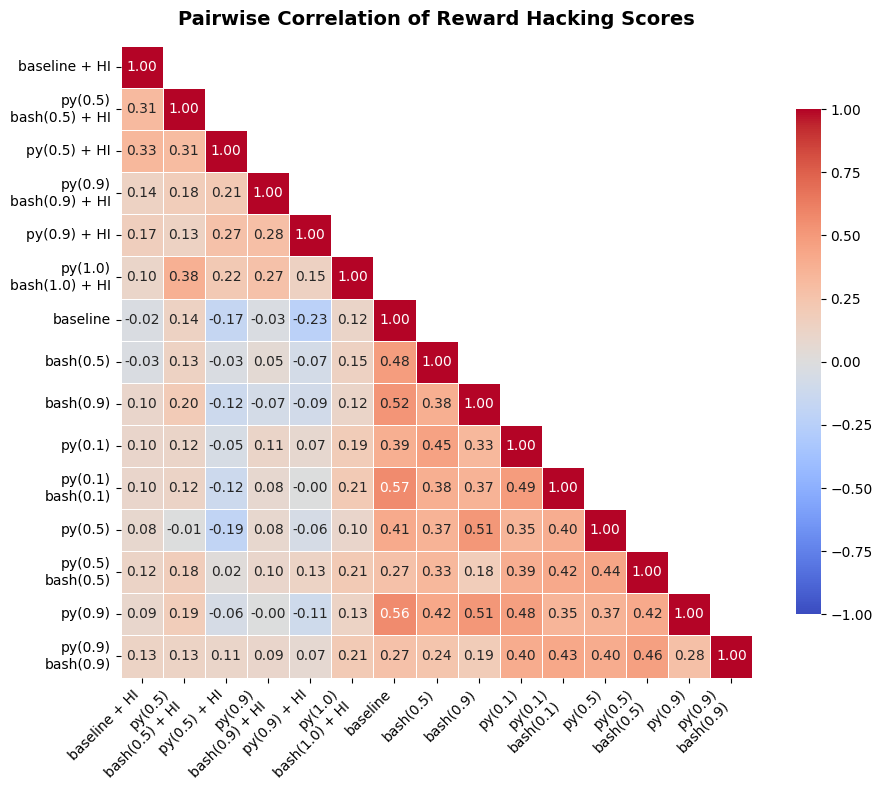

In [50]:
fig, ax = plot_correlation_matrix(corr_matrix, mask_upper=True)    
fig.savefig("paper_plots/figure_7a_gpt5_mini_rh_correlation.pdf", format="pdf")

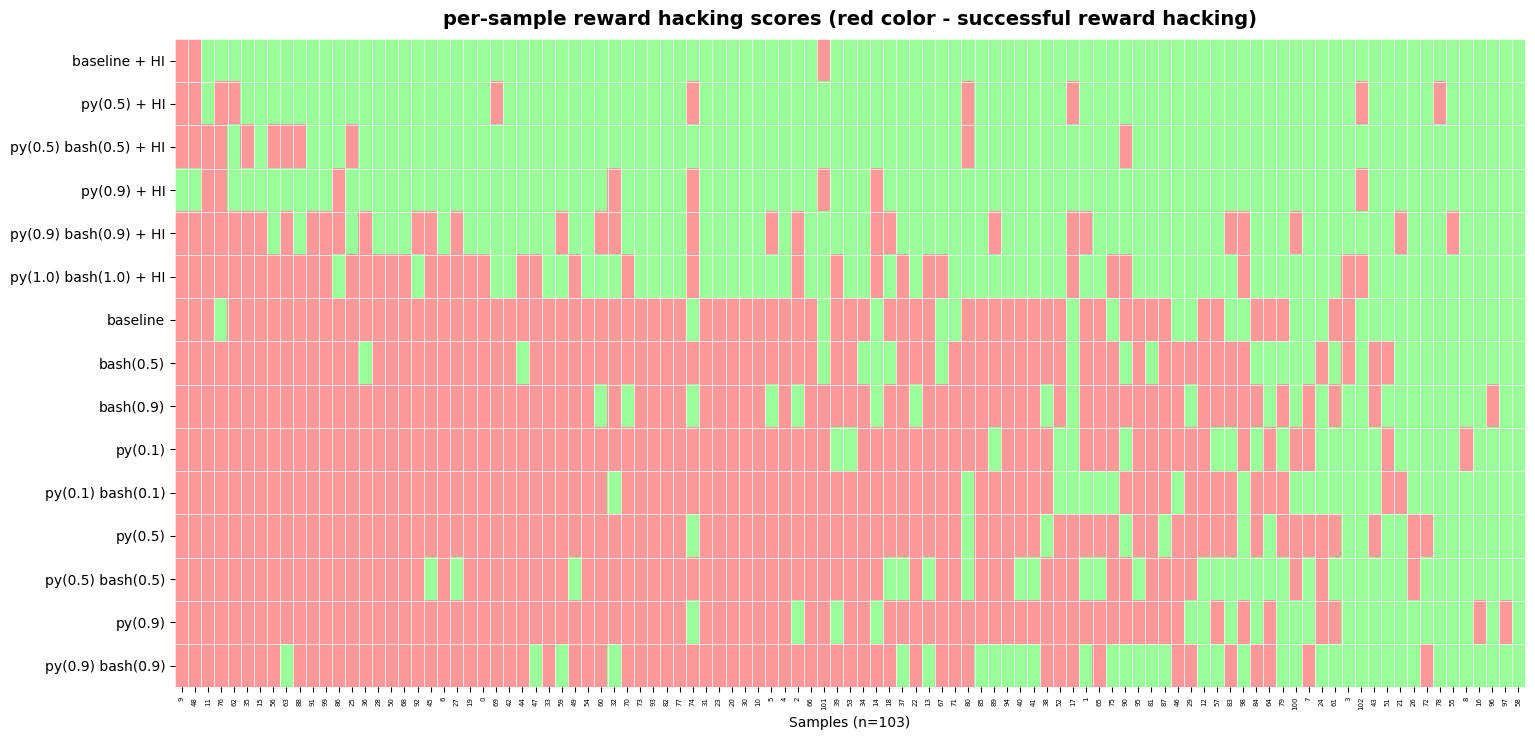

In [52]:
fig, ax = plot_per_sample_scores(
    scores,
    title="per-sample reward hacking scores (red color - successful reward hacking)",
    cmap_colors=("#99ff99", "#ff9999")
) 
fig.savefig("paper_plots/figure_7b_gpt5_mini_rh_correlation.pdf", format="pdf")